In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
#Data taken from https://www.edmundoptics.com/p/50mm-diameter-vacuum-uv-enhanced-mirror/3368/

MIRROR_670_JSON  = Path("../DATA/Mirror_Reflectivity_120_670.json")
MIRROR_2520_JSON = Path("../DATA/Mirror_Reflectivity_120_2520.json")

In [3]:
def load_reflectivity(path: Path):
    with path.open("r") as f:
        j = json.load(f)

    data = j["datasetColl"][0]["data"]
    arr = np.array([p["value"] for p in data], dtype=float)
    w = arr[:, 0]
    R = arr[:, 1]

    idx = np.argsort(w)
    w = w[idx]
    R = R[idx]

    w_unique, inv = np.unique(w, return_inverse=True)
    if len(w_unique) != len(w):
        R_accum = np.zeros_like(w_unique)
        counts = np.zeros_like(w_unique)
        np.add.at(R_accum, inv, R)
        np.add.at(counts, inv, 1.0)
        R = R_accum / counts
        w = w_unique

    return w, R


def make_interpolator(w, R, kind="pchip"):
    if kind == "pchip":
        try:
            from scipy.interpolate import PchipInterpolator
            print("Using PCHIP interpolation")
            f = PchipInterpolator(w, R, extrapolate=False)
            return lambda x: f(x)
        except Exception:
            print("SciPy not available → falling back to linear")
            kind = "linear"

    if kind == "cubic":
        try:
            from scipy.interpolate import CubicSpline
            print("Using CubicSpline interpolation")
            f = CubicSpline(w, R, bc_type="natural", extrapolate=False)
            return lambda x: f(x)
        except Exception:
            print("CubicSpline failed → falling back to linear")
            kind = "linear"

    print("Using linear interpolation")
    return lambda x: np.interp(x, w, R)

def stitch_curves(w1, R1, w2, R2, join=None, blend_nm=30.0, n=4000, interp_kind="pchip"):
    f1 = make_interpolator(w1, R1, kind=interp_kind)
    f2 = make_interpolator(w2, R2, kind=interp_kind)

    if join is None:
        join = float(w1.max())

    wmin = max(float(w1.min()), float(w2.min()))
    wmax = min(float(w1.max()), float(w2.max()))  
    full_max = float(w2.max())

    w_out = np.linspace(wmin, full_max, n)

    R1_out = f1(w_out)
    R2_out = f2(w_out)

    R_out = np.where(w_out <= join, R1_out, R2_out)

    if blend_nm and blend_nm > 0:
        a = join - blend_nm
        b = join + blend_nm
        mask = (w_out >= a) & (w_out <= b)

        t = (w_out[mask] - a) / (b - a)
        w1_weight = 1.0 - t
        w2_weight = t

        valid = np.isfinite(R1_out[mask]) & np.isfinite(R2_out[mask])
        tmp = R_out[mask].copy()
        tmp[valid] = w1_weight[valid] * R1_out[mask][valid] + w2_weight[valid] * R2_out[mask][valid]
        R_out[mask] = tmp

    return w_out, R_out

In [4]:
w1, R1 = load_reflectivity(MIRROR_670_JSON)
w2, R2 = load_reflectivity(MIRROR_2520_JSON)

w_merged, R_merged = stitch_curves(
    w1, R1, w2, R2,
    join=float(w1.max()),     
    blend_nm=30.0,           
    n=5000,
    interp_kind="pchip"       
)

Using PCHIP interpolation
Using PCHIP interpolation


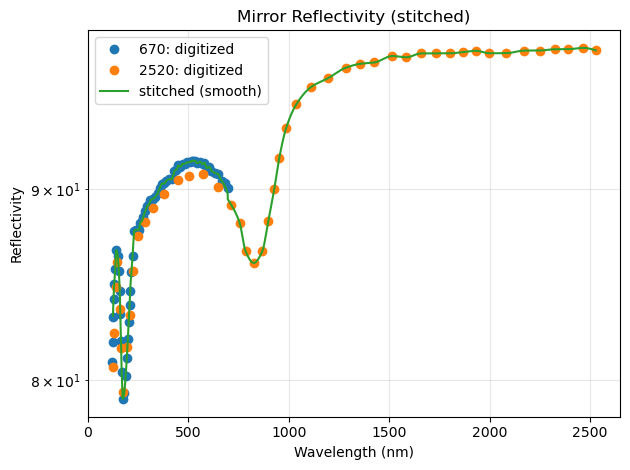

In [5]:
plt.figure()
plt.plot(w1, R1, "o", label="670: digitized")
plt.plot(w2, R2, "o", label="2520: digitized")
plt.plot(w_merged, R_merged, "-", label="stitched (smooth)")
plt.yscale("log")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectivity")
plt.title("Mirror Reflectivity (stitched)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
import numpy as np

def export_for_geant_wl_table(
    w_nm,
    R_percent,
    max_points=80,
    decimals=6,
    round_wavelengths=True,  # set True if you want integer nm
):
    w = np.asarray(w_nm, dtype=float)
    R = np.asarray(R_percent, dtype=float)

    # sort by wavelength
    idx = np.argsort(w)
    w = w[idx]
    R = R[idx]

    # convert percent -> [0,1]
    R = R / 100.0

    # remove duplicate wavelengths by averaging
    w_unique, inv = np.unique(w, return_inverse=True)
    if len(w_unique) != len(w):
        R_accum = np.zeros_like(w_unique)
        counts = np.zeros_like(w_unique)
        np.add.at(R_accum, inv, R)
        np.add.at(counts, inv, 1.0)
        R = R_accum / counts
        w = w_unique

    # clamp physically
    R = np.clip(R, 0.0, 1.0)

    # downsample if needed (uniform in index; fine for smooth curves)
    if max_points is not None and len(w) > max_points:
        pick = np.linspace(0, len(w) - 1, max_points).astype(int)
        w = w[pick]
        R = R[pick]

    # wavelength formatting
    if round_wavelengths:
        wl_out = np.round(w).astype(int)
        wl_str = ", ".join(str(int(x)) for x in wl_out)
    else:
        wl_str = ", ".join(f"{x:.6f}" for x in w)

    r_str = ", ".join(f"{y:.{decimals}f}" for y in R)

    print("\n--- Paste into C++ ---\n")
    print("static const G4double wl_nm[] = {")
    print("  " + wl_str)
    print("};\n")
    print("static const G4double R_wl[] = {")
    print("  " + r_str)
    print("};\n")
    print(f"// Total points: {len(w)}")
    print(f"// R range (fraction): min={R.min():.6f}, max={R.max():.6f}")

In [10]:
export_for_geant_wl_table(w_merged, R_merged, max_points=40)


--- Paste into C++ ---

static const G4double wl_nm[] = {
  124, 186, 247, 309, 370, 432, 494, 556, 617, 679, 740, 802, 864, 926, 987, 1049, 1110, 1172, 1234, 1295, 1357, 1418, 1480, 1542, 1604, 1665, 1727, 1788, 1850, 1912, 1973, 2035, 2097, 2158, 2220, 2282, 2343, 2405, 2466, 2528
};

static const G4double R_wl[] = {
  0.832290, 0.799592, 0.877779, 0.893290, 0.903189, 0.910437, 0.915101, 0.915373, 0.910208, 0.902431, 0.885707, 0.862314, 0.865241, 0.899030, 0.934935, 0.950649, 0.958727, 0.962652, 0.966931, 0.970796, 0.972657, 0.973316, 0.976122, 0.977078, 0.976938, 0.978912, 0.978930, 0.978947, 0.979486, 0.980409, 0.979433, 0.979022, 0.979155, 0.980513, 0.980629, 0.980967, 0.981443, 0.981540, 0.982250, 0.980730
};

// Total points: 40
// R range (fraction): min=0.799592, max=0.982250
